<a href="https://colab.research.google.com/github/pvanand07/NIFTY50-Daily-Trend-Prediction-Using-NLP-Python/blob/master/NIFTY50_Prediction_Twitter_NLP_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements for Google Collab
1. Run the following cell
2. Restart Kernel

In [5]:
#For webscraping
!pip3 install snscrape;
#For FinBERT
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 KB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 83.7 MB/s eta 0:00:00


## Import Necessory Libraries

In [6]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [7]:
# For FinBERT
from transformers import pipeline
classifier = pipeline('sentiment-analysis', model="ProsusAI/finbert")


## Obtaining Tweets

In [8]:
# Define the keyword and the number of tweets to scrape
QUERY = 'nifty50'
N_TWEETS = 500

# Create an empty list to store the attributes of the tweets
attributes_container = []

# Scrape the tweets and extract the specified attributes
for i, tweet in tqdm(
    enumerate(sntwitter.TwitterSearchScraper(QUERY).get_items()), total=N_TWEETS
):
    if i > N_TWEETS:
        break

    attributes_container.append(
        [
            tweet.user.followersCount,
            tweet.date,
            tweet.likeCount,
            tweet.content,
            tweet.hashtags,
        ]
    )

# Create a dataframe from the attributes list
tweets_df = pd.DataFrame(
    attributes_container,
    columns=[
        "Follows_Count",
        "Date_Created",
        "Like_Count",
        "tweet_Content",
        "Hashtags",
    ],
)


  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-8-691b17221ae9>:20: FutureWarning: content is deprecated, use rawContent instead
  tweet.content,
501it [00:19, 25.16it/s]                         


## Generating Wordcloud

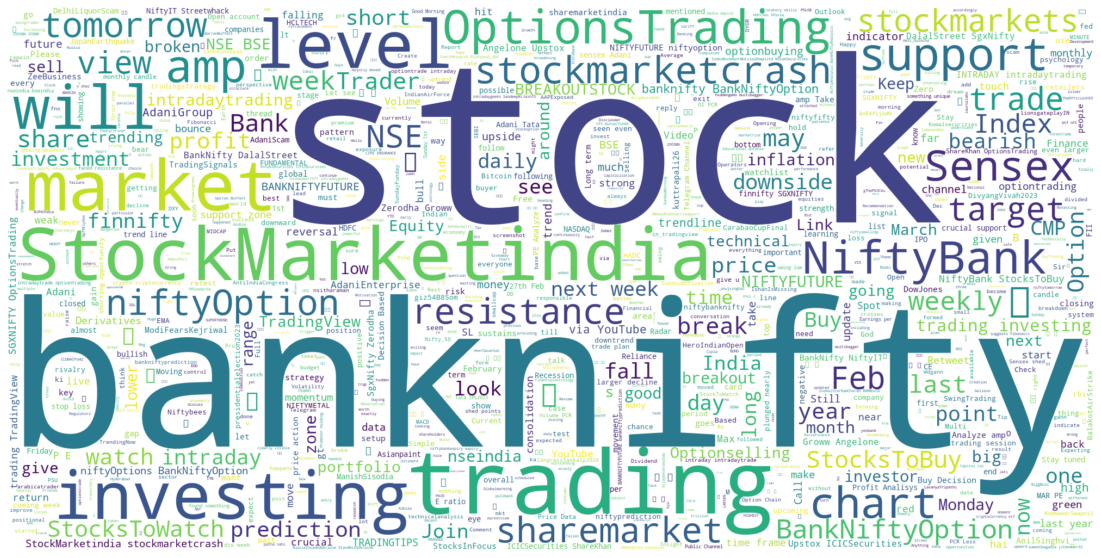

In [9]:
# Create a string of all the tweets
tweets_string = ' '.join(tweets_df['tweet_Content'])

# Create a set of stopwords
stopwords = set(STOPWORDS)
stopwords.update(["RT","https","co","nifty50","min","RSI","nifty","stockmarket","t","finantial","Analysis","business",":","30"])

# Create a word cloud object
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=2000,
                      height=1000,
                      max_words=1000,
                      contour_width=3,
                      contour_color='steelblue').generate(tweets_string)

# Plot the word cloud
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis Using TextBlob

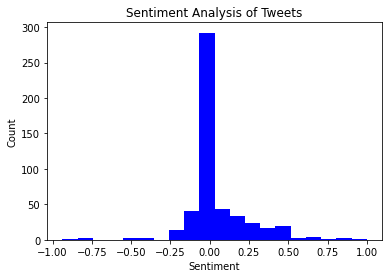

In [19]:

from textblob import TextBlob

# Add a new column to the dataframe to store the sentiment
tweets_df['Sentiment'] = tweets_df['tweet_Content'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Create a histogram of the sentiment
plt.hist(tweets_df['Sentiment'], bins=20, color='blue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis of Tweets')
plt.show()

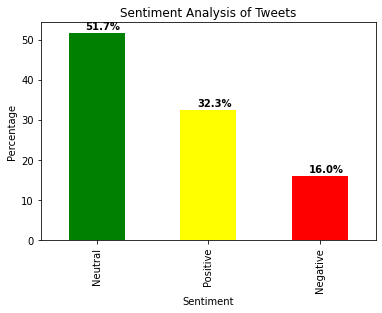

In [20]:
# Create a new column to categorize the sentiment as positive, neutral or negative
tweets_df['Sentiment_Category'] = tweets_df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Neutral' if x == 0 else 'Negative')

# Calculate the percentage of each sentiment category
sentiment_counts = tweets_df['Sentiment_Category'].value_counts(normalize=True) * 100

# Create a bar plot of the sentiment category with percentage values on top of bars
ax = sentiment_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.set_title('Sentiment Analysis of Tweets')

# Add percentage values on top of bars
for i, v in enumerate(sentiment_counts):
    ax.text(i - 0.1, v + 1, f'{v:.1f}%', color='black', fontweight='bold')

plt.show()


In [12]:
tweets_df['Sentiment_Category'].value_counts()*100/len(tweets_df)

Neutral     51.696607
Positive    32.335329
Negative    15.968064
Name: Sentiment_Category, dtype: float64

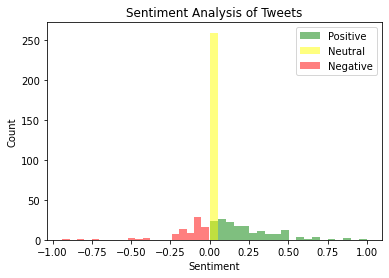

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Create a histogram of the sentiment
plt.hist(tweets_df[tweets_df['Sentiment'] > 0]['Sentiment'], bins=20, color='green', alpha=0.5, label='Positive')
plt.hist(tweets_df[tweets_df['Sentiment'] == 0]['Sentiment'], bins=20, color='yellow', alpha=0.5, label='Neutral')
plt.hist(tweets_df[tweets_df['Sentiment'] < 0]['Sentiment'], bins=20, color='red', alpha=0.5, label='Negative')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend()
plt.title('Sentiment Analysis of Tweets')
plt.show()

##Sentiment Analysis Using FinBERT

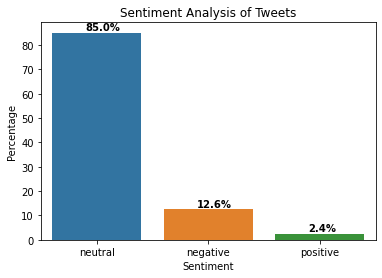

In [23]:
from tqdm import tqdm

# Add a new column to the dataframe to store the sentiment
tweets_df['Sentiment'] = [classifier(x)[0]['label'] for x in tqdm(tweets_df['tweet_Content'])]

# Count the number of tweets for each sentiment
counts = tweets_df['Sentiment'].value_counts()

# Calculate the percentage of each sentiment category
sentiment_counts = counts / len(tweets_df) * 100

# Plot the sentiment counts using a bar plot with percentage values on top of bars
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.set_title('Sentiment Analysis of Tweets')

# Add percentage values on top of bars
for i, v in enumerate(sentiment_counts):
    ax.text(i - 0.1, v + 1, f'{v:.1f}%', color='black', fontweight='bold')

# Show the plot
plt.show()

In [15]:
#counts = tweets_df['Sentiment']
#sns.histplot(data = counts)

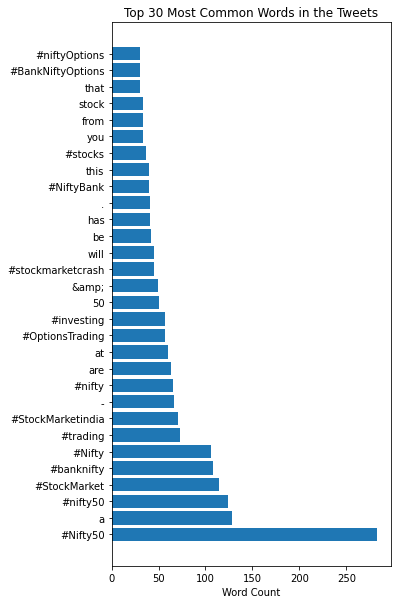

In [16]:
from collections import Counter
import matplotlib.pyplot as plt

# Create a list of all the words in the tweets
words_list = ' '.join(tweets_df['tweet_Content']).split()
unwanted_words = ['the', 'and', 'is', 'in', 'to', 'of', 'it', 'with', 'for', 'on',':','30',"RT","https","co","nifty50","min","RSI","nifty","stockmarket","t","finantial","Analysis","business",]

# Use a list comprehension to remove the unwanted words from the original list
filtered_words = [word for word in words_list if word.lower() not in unwanted_words]
# Count the frequency of each word
word_counts = Counter(filtered_words)

# Get the top 10 most common words
top_words = word_counts.most_common(30)
plt.figure(figsize=(5,10))
# Create a horizontal bar plot of the word counts
plt.barh(range(len(top_words)), [count for _,count in top_words], align='center')
plt.yticks(range(len(top_words)), [word for word, _ in top_words])
plt.xlabel('Word Count')
plt.title('Top 30 Most Common Words in the Tweets')
plt.show()

In [17]:
# Sample FinBERT Classifier Output
classifier("We hope you don't hate it.")

[{'label': 'neutral', 'score': 0.7994503974914551}]